<a href="https://colab.research.google.com/github/leticiaram/Modelacion-Epidemiologica/blob/main/2_Ajuste_Numerico_modelo_SIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalando y cargando paquetes

In [1]:
!pip install lmfit
from lmfit import minimize, Parameters, Parameter, report_fit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.7/97.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 4.7 MB/s eta 0:00:00


**lmfit**

El paquete lmfit de Python es una biblioteca de ajuste de modelos y optimización de parámetros de alto nivel. Se construye sobre los fundamentos de scipy.optimize (como curve_fit y leastsq) pero ofrece una interfaz mucho más poderosa, flexible y fácil de usar para problemas de ajuste de curvas no lineales.

**Múltiples Minimizadores** Incluye una amplia gama de algoritmos de minimización (Levenberg-Marquardt, Nelder-Mead, emcee para MCMC, etc.) detrás de una interfaz unificada. Puedes cambiar el método de optimización con solo un argumento.

In [2]:
import scipy.integrate as spi
import numpy as np
import pylab as pl

In [3]:
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
%precision 4
plt.style.use('ggplot')
from scipy.integrate import odeint


# Modelo SIR

In [4]:
def ode_SIR(INP,t,ps):
    try:
        beta = ps['beta'].value
        gamma = ps['gamma'].value
        N = ps['N'].value
    except:
        beta,gamma,N = ps

    Y = np.zeros((3))
    V = INP
    Y[0] = - beta * V[0] * V[1] /N
    Y[1] = beta * V[0] * V[1]/N - gamma * V[1]
    Y[2] = gamma * V[1]
    return Y


# Solución numérica del modelo

In [5]:
def g(t,INP,ps):
    SOL = spi.odeint(ode_SIR,INPUT,t_range,args=(ps,))
    return SOL

# Función que reporta los residuales

In [70]:
def residual(ps,ts,data):
    INP = ps['S0'].value, ps['I0'].value, 0.0
    model = g(ts,INP,ps)
    return (model[:,1]-data)

# Ejemplo

## Inferencia basada en la prevalencia

### Simulamos datos con las siguientes condiciones iniciales y parámetros

In [114]:
beta = 1.42
gamma = 0.142
N = 1000
true_params = np.array((beta, gamma,N))

S0 = 1000-1
I0 = 1
INPUT = (S0, I0, 0.0)

t_start = 0.0; t_end = 50; t_inc = 1.0
t_range = np.arange(t_start, t_end+t_inc, t_inc)

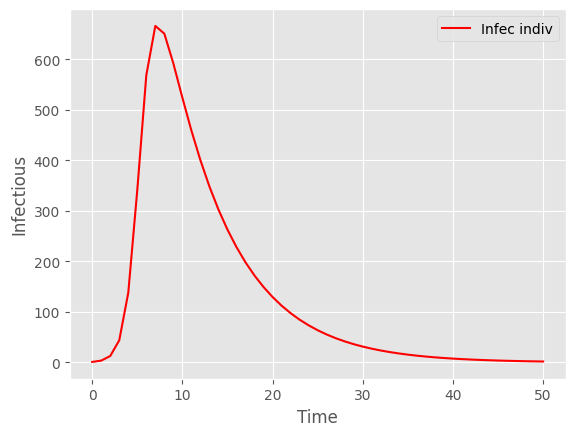

In [115]:
data = g(t_range,INPUT, true_params)
#Ploting
pl.plot(data[:,1], '-r', label='Infec indiv')
pl.legend(loc=0)
pl.xlabel('Time')
pl.ylabel('Infectious')
pl.show()

Los datos son solo los de la prevalencia (I):

In [116]:
data = data[:,1]

### Los datos son la solución anterior más ruido

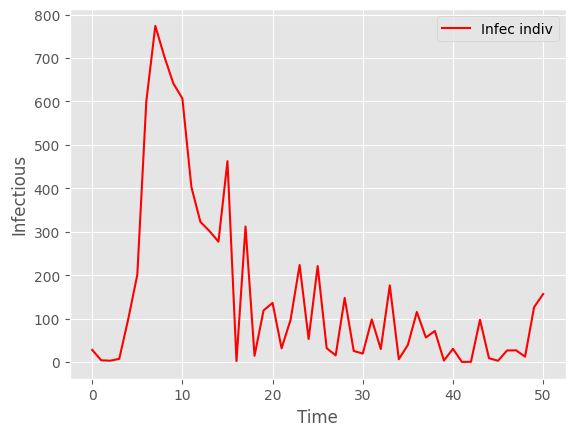

In [118]:
np.random.seed(34)

data += np.random.normal(size=data.shape,scale=50)
data = abs(data)
#Ploting
pl.plot(data, '-r', label='Infec indiv')
pl.legend(loc=0)
pl.xlabel('Time')
pl.ylabel('Infectious')
pl.show()

### Para ajustar los valores de los parámetros, establecemos rangos factibles

In [119]:
# set parameters incluing bounds
params = Parameters()
params.add('beta', value=2.0, min=0, max=10)
params.add('gamma', value=1.0, min=0, max=10)
params.add('N', value=float(N)) # Lo definimos conocido
params.add('S0', value= float(N-data[0]), min=0, max=1000)
params.add('I0', value=float(data[0]), min=0, max=100)

In [51]:
params

name,value,initial value,min,max,vary
beta,2.00000000,2.0,0.00000000,10.0000000,True
gamma,1.00000000,1.0,0.00000000,10.0000000,True
N,1000.00000,1000.0,-inf,inf,True
S0,984.369894,984.369893962336,0.00000000,1000.00000,True
I0,15.6301060,15.630106037663973,0.00000000,100.000000,True


### Vemos que valor tiene el residual para los valores iniciales:

In [120]:
sol_ini = g(t=t_range,INP=[1000,984,15],ps=test_params)
sol_ini.shape

(51, 3)

In [121]:
sol_ini_I=sol_ini[:,1]

2544663.6451763217


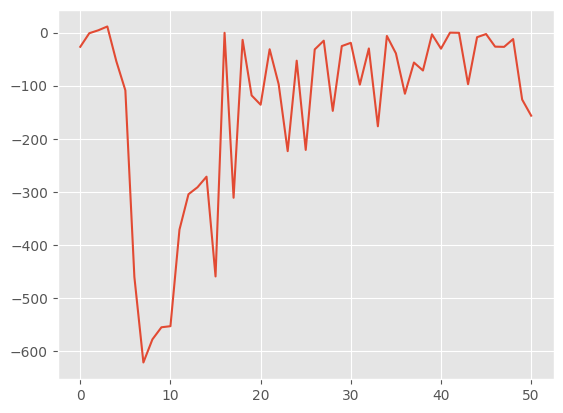

In [122]:
test_params = Parameters()
test_params.add('beta', value=2.0)
test_params.add('gamma', value=1)
test_params.add('N', value=1000)
test_params.add('S0', value=1000)
test_params.add('I0', value=43)

res=residual(ps=test_params, ts=t_range, data=data)
pl.plot(res)
print(np.sum(res**2))

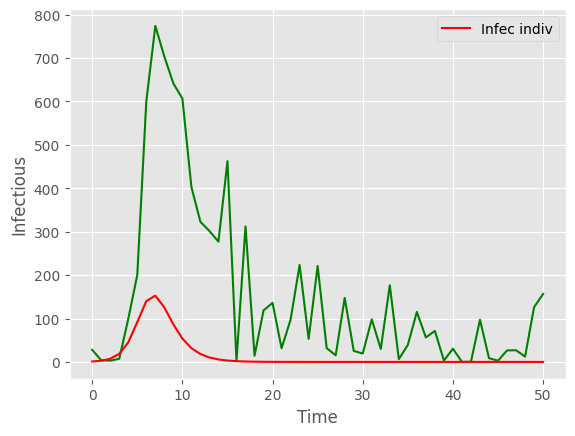

In [123]:
pl.plot(data, '-g')
plt.plot(sol_ini[:,1], '-r', label='Infec indiv')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('Infectious')
plt.show()

### Ahora procedemos a realizar el ajuste

La función `minimize()` es el caballo de batalla para la optimización y ofrece una amplia gama de **métodos de optimización** (también llamados *solvers* u *optimizadores*). Estos métodos se pasan a través del parámetro `method`.

Algunos optimizadores disponibles, organizados por categorías son:

1. **Métodos Escalares (Para optimización 1-D)**
Estos métodos se utilizan para minimizar funciones de una sola variable.
  *   **`'nelder'`**: Una versión del algoritmo **Nelder-Mead** (símplex) adaptada para funciones escalares.
  *   **`'powell'`** : Método de **Powell** para optimización escalar.

2. **Algoritmos de Minimos Cuadrados No Lineales**
Estos métodos son altamente eficientes para problemas donde la función objetivo es una suma de residuos al cuadrado (es decir, ajuste de curvas).

  *  **`'leastsq'`**: **Levenberg-Marquardt** (por defecto). El algoritmo más popular y rápido para ajustes de mínimos cuadrados no lineales. Solo puede buscar mínimos locales.
  *  **`'least_squares'`**: Una interfaz para el solucionador `scipy.optimize.least_squares`. Ofrece más opciones para controlar el comportamiento (como `'trf'` - Trust Region Reflective y `'dogbox'`) que el método `leastsq` tradicional.
  *  **`'lsq'`**: Un alias para `'least_squares'`.

3. **Algoritmos de Optimización Local General**
Estos métodos pueden manejar funciones objetivo generales (no solo mínimos cuadrados) y suelen requerir el cálculo del gradiente.
  *  **`'bfgs'`**: **Broyden–Fletcher–Goldfarb–Shanno**. Un método quasi-Newton muy popular que aproxima la matriz Hessiana.
  *  **`'cg'`**: **Gradiente conjugado**. Eficiente para problemas a gran escala.
  *  **`'l-bfgs-b'`**: Versión de **BFGS con memoria limitada**. Muy eficiente para problemas con muchas variables y que admite límites (bounds).
  *  **`'tnc'`**: **Newton truncado**. Un método que admite límites.
  *  **`'newton'`**: Método de **Newton** clásico para encontrar ceros de una función. Requiere el jacobiano.

4. **Algoritmos Globales y Estocásticos**
Estos métodos intentan encontrar el **mínimo global** de la función, evitando quedar atrapados en mínimos locales. Son mucho más costosos computacionalmente.

  *  **`'differential_evolution'`**: **Evolución diferencial**. Un algoritmo estocástico muy robusto para encontrar el mínimo global. Admite límites.
  *  **`'brute'`**: **Búsqueda por fuerza bruta** en una cuadrícula. Muy lento, solo útil para un número pequeño de parámetros.
  *  **`'basinhopping'`**: **Basin-Hopping**. Combina una fase de salto estocástico global con una minimización local. Efectivo para paisajes energéticos rugosos.


5. **Métodos personalizados y de propósito específico**

  *  **`'emcee'`**: No es un minimizador tradicional, sino un **muestreador de Monte Carlo basado en cadenas de Markov (MCMC)**. Se utiliza para explorar la distribución de probabilidad posterior de los parámetros y estimar incertidumbres, en lugar de encontrar simplemente un mínimo.
  *  **`'ampgo'`**: **Adapted Memory Programming for Global Optimization**.



In [124]:
# fit model and find predicted values
t = np.linspace(0, 10, 100)
result = minimize(residual, params, args=(t, data), method='leastsq')
result

Recordamos los verdaderos valores

'beta = 1.42

gamma = 0.142

N = 1000

S0 = 1000-1

I0 = 1

INPUT = (S0, I0, 0.0)'

### Graficamos los datos y la curva del modelo ajustado

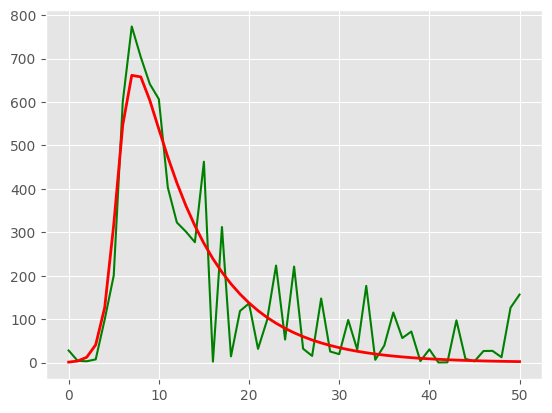

In [125]:
final = data + result.residual

# plot data and fitted curves
pl.plot(data, '-g')
pl.plot(final, '-r', linewidth=2);

## Inferencia basada en la incidencia

### Simulamos datos con las siguientes condiciones iniciales y parámetros

In [126]:
beta = 1.42
gamma = 0.142
N = 1000
true_params = np.array((beta, gamma,N))

S0 = 1000-1
I0 = 1
INPUT = (S0, I0, 0.0)

t_start = 0.0; t_end = 30; t_inc = 1.0
t_range = np.arange(t_start, t_end+t_inc, t_inc)

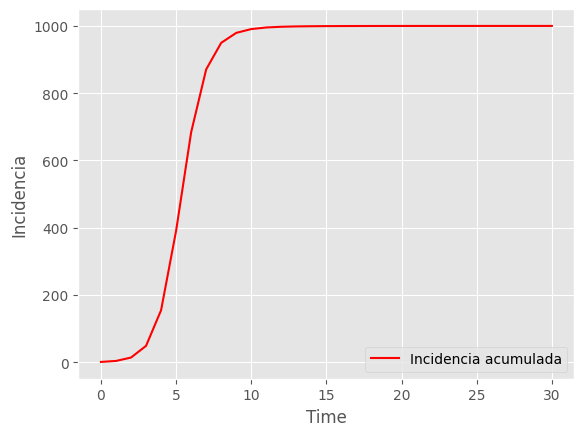

In [127]:
data = g(t_range,INPUT, true_params)
incidencia_acumulada = N-data[:,0]
#Ploting
pl.plot(incidencia_acumulada, '-r', label='Incidencia acumulada')
pl.legend(loc=0)
pl.xlabel('Time')
pl.ylabel('Incidencia')
pl.show()

Obtenemos la incidencia diaria

/tmp/ipython-input-2797580298.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  pl.legend(loc=0)


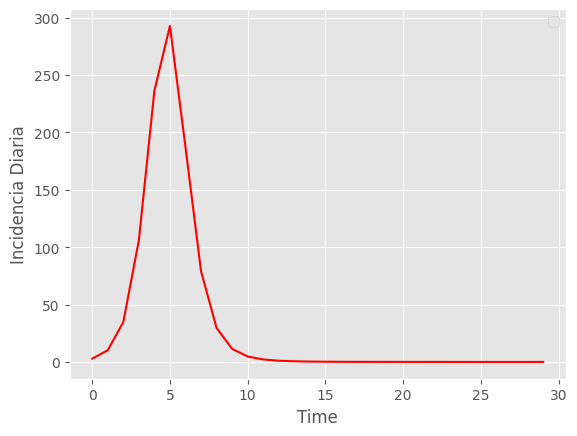

In [128]:
incidencia_diaria = np.diff(incidencia_acumulada)
#Ploting
pl.plot(incidencia_diaria, '-r')
pl.legend(loc=0)
pl.xlabel('Time')
pl.ylabel('Incidencia Diaria')
pl.show()

Añadimos ruido

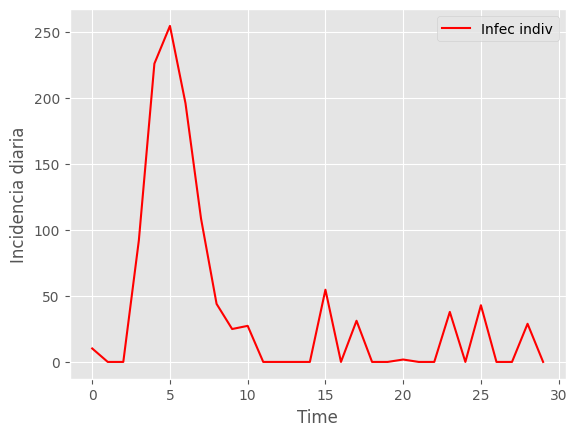

In [129]:
np.random.seed(34)

data_ruido = incidencia_diaria + np.random.normal(size=incidencia_diaria.shape,scale = 30)
data = np.where(data_ruido > 0, data_ruido, 0)  #note que ahora estamos censurando en 0
#Ploting
pl.plot(data, '-r', label='Infec indiv')
pl.legend(loc=0)
pl.xlabel('Time')
pl.ylabel('Incidencia diaria')
pl.show()

Tenemos que redefinir la función que nos da el error para comparar la incidencias

In [151]:
def residual_incidencias(ps,ts,data):
    INP = ps['S0'].value, ps['I0'].value, 0.0
    model = np.diff(ps['N'].value - g(ts,INP,ps)[:,0])
    return (model-data)

### Establecemos rangos factibles

In [152]:
# set parameters incluing bounds
params = Parameters()
params.add('beta', value=2.0, min=0, max=10)
params.add('gamma', value=1.0, min=0, max=10)
params.add('N', value=float(N)) # Lo definimos conocido
params.add('S0', value= float(N-data[0]), min=0, max=1000)
params.add('I0', value=float(data[0]), min=0, max=100)

In [134]:
params

name,value,initial value,min,max,vary
beta,2.00000000,2.0,0.00000000,10.0000000,True
gamma,1.00000000,1.0,0.00000000,10.0000000,True
N,1000.00000,1000.0,-inf,inf,True
S0,989.819084,989.8190838380626,0.00000000,1000.00000,True
I0,10.1809162,10.18091616193733,0.00000000,100.000000,True


Vemos que valor tiene el residual para los valores iniciales:

32302.202368511447


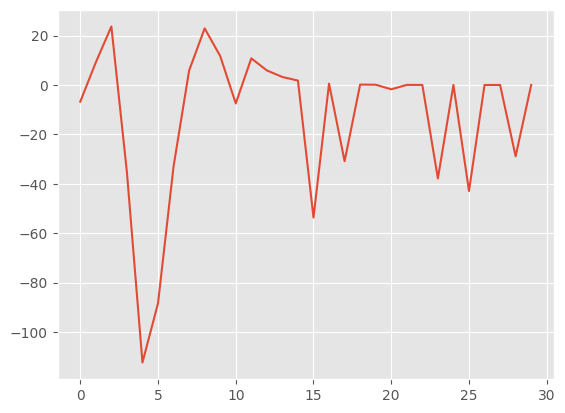

In [154]:
test_params = Parameters()
test_params.add('beta', value = 2.0)
test_params.add('gamma', value = 1)
test_params.add('N', value = 1000)
test_params.add('S0', value = 989)
test_params.add('I0', value = 10)

re = residual_incidencias(ps = test_params, ts = t_range, data = data)
pl.plot(res)
print(np.sum(res**2))

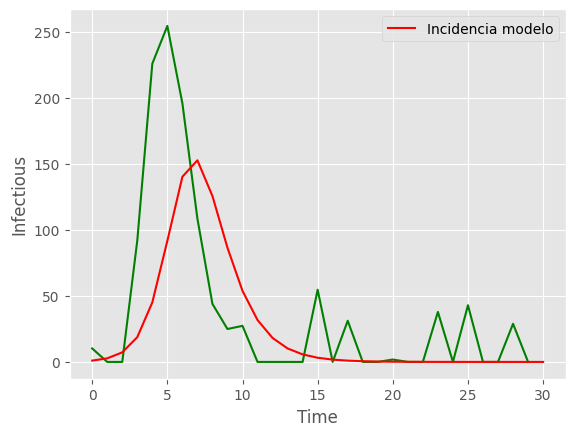

In [156]:
pl.plot(data, '-g')
plt.plot(sol_ini[:,1], '-r', label='Incidencia modelo')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('Infectious')
plt.show()

### Ahora procedemos a realizar el ajuste

In [157]:
# fit model and find predicted values
t = np.linspace(0, 10, 100)
result = minimize(residual_incidencias, params, args=(t, data), method='leastsq')
result

### Graficamos los datos y la curva del modelo ajustado

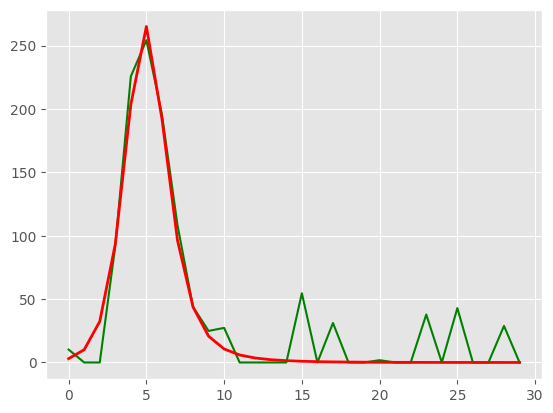

In [158]:
final = data + result.residual

# plot data and fitted curves
pl.plot(data, '-g')
pl.plot(final, '-r', linewidth=2);